# Beginners Guide to `caskade`

Here we will introduce all of the relevant concepts and capabilities of `caskade` and how to build numerical simulators.

In [1]:
from caskade import Module, Param, forward
import torch

## Basic Template

All `caskade` simulators follow the same basic template. Certain ingredients are always involved:

- Subclass the `Module` object
- Call the `super().__init__()` at the top
- Create some `Param` attributes
- Decorate a function with `@forward`
- Include some of the params (by attribute name) as keyword arguments

You can also provide a name for the `Module`, though this is optional. If not given, then a unique name will be made from the class name and a counter of the form `ClassName_i`. Note that for both the `__init__` and `@forward` methods you may have any other positional parameters or keyword parameters you like, they will not interfere. Keep in mind that for the `@forward` method when requesting a `Param` value, you must set it as a keyword argument, usually just by defaulting to `None`.

In [2]:
class MyFirstSim(Module):
    def __init__(self, name, a=None, b=None, c_shape=()):
        super().__init__(name) # optional name for the module
        self.a = Param("a", a) # standard parameter
        self.b = Param("b param", b) # note name can be anything we want
        self.c = Param("c", None, c_shape) # Here we only provide a shape, not a value

    @forward
    def myfunction(self, x, a=None, b=None, c=None, d = 1):
        return x * a + b + c + d

We may now create instances of this class, which let us set parameters in the init. We can print the object to see a dictionary which shows the graph structure. Alternatively, we can produce a `graphviz` representation (`Digraph`) of the graph structure.

myfirstname|module
    a|static
    b param|dynamic
    c|dynamic


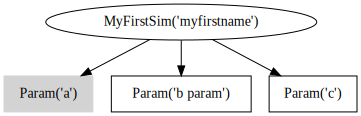

In [3]:
firstsim = MyFirstSim("myfirstname", a = 1.0, c_shape=(2, 2))
print(firstsim) # show the graph which is just a static and two dynamic parameters
firstsim.graphviz() # show the graph in a window

Finally, we can build our list of parameters and pass them to the function as the last positional argument (or a few other ways).

In [4]:
#                      b                    c
params = [torch.tensor(2.0), torch.tensor([[1.0, 2.0], [3.0, 4.0]])]
print(firstsim.myfunction(1.0, params, d = 2))

tensor([[6., 7.],
        [8., 9.]])


## Different ways to pass the parameters

Let's explore a few different ways that one can pass the parameters into a `caskade` forward method. First, we can change what the `params` construct looks like depending on what is convenient for our purposes. A list is nice since we can break up the list into more manageable chunks (such as one list for the parameters in a given module) then just add the lists together later to make the `params` object. A single flattened `Tensor` is nice since many other codes (think `scipy.minimize`, `emcee`, etc.) like to work with an input `x` that is just a single vector. A dictionary may be conceptually easier to construct, either alongside building your simulator, or just writing out manually, since it follows the same structure as the simulator graph.

In [5]:
# List of tensors (this is what we did above)
params_list = [torch.tensor(2.0), torch.tensor([[1.0, 2.0], [3.0, 4.0]])]
print("List of tensors: ", firstsim.myfunction(1.0, params_list, d = 2))

# Single flattened tensor
params_tensor = torch.cat([p.flatten() for p in params_list])
print("Single flattened tensor: ", firstsim.myfunction(1.0, params_tensor, d = 2))

# Dictionary of tensors
params_dict = {"b": torch.tensor(2.0), "c": torch.tensor([[1.0, 2.0], [3.0, 4.0]])}
print("Dictionary of tensors: ", firstsim.myfunction(1.0, params_dict, d = 2))

List of tensors:  tensor([[6., 7.],
        [8., 9.]])
Single flattened tensor:  tensor([[6., 7.],
        [8., 9.]])
Dictionary of tensors:  tensor([[6., 7.],
        [8., 9.]])


Next, once we have the `params` there are a couple ways we can get it into the forward method. So far we have just been setting the last positional argument as the params, but we can also pass it as a keyword, or if the parameters aren't going to change very much we can set them as static.

In [6]:
# Pass as last positional argument
print("Last positional argument: ", firstsim.myfunction(1.0, params_list, d = 2))

# Pass as keyword argument
print("Keyword argument: ", firstsim.myfunction(1.0, params=params_list, d = 2))

# Set parameters as static
firstsim.b = params_list[0]
firstsim.c = params_list[1]
print("Set parameters as static: ", firstsim.myfunction(1.0, d = 2))
# Set them back to dynamic
firstsim.b = None
firstsim.c = None

Last positional argument:  tensor([[6., 7.],
        [8., 9.]])
Keyword argument:  tensor([[6., 7.],
        [8., 9.]])
Set parameters as static:  tensor([[6., 7.],
        [8., 9.]])


## Different types of parameters

So far we have only looked at `dynamic` and `static` parameters. `caskade` allows users to build complex simulators with relationships between parameters. Next lets see the `pointer` type: 

- `dynamic` is given as input when calling a `@forward` method
- `static` is a fixed value
- `pointer` returns the value computed from other nodes in the graph

In [7]:
# Make a basic pointer parameter
firstsim.b = firstsim.a

Pointer parameter:  tensor([[5., 6.],
        [7., 8.]])


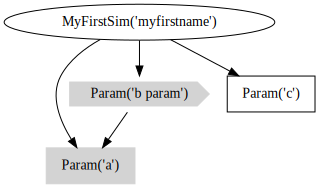

In [8]:
params_dict = {"c": torch.tensor([[1.0, 2.0], [3.0, 4.0]])} # note no "b"
print("Pointer parameter: ", firstsim.myfunction(1.0, params_dict, d = 2))
firstsim.graphviz()

As you can see, a `pointer` parameter is represented in the graph as a shaded arrow.

Function parameter:  tensor([[6., 7.],
        [8., 9.]])


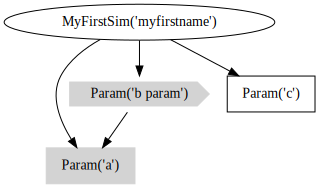

In [9]:
# Make a pointer function
firstsim.b = lambda p: p["a link"].value * 2
firstsim.b.link("a link", firstsim.a) # have to manually link the parameter
print("Function parameter: ", firstsim.myfunction(1.0, params_dict, d = 2))
firstsim.graphviz()

## Nesting Modules

Thus far we have only worked with simulators that are a single `Module`, while the capability of `caskade` is nice at this level it is somewhat overkill for such a scenario as you could just manually make the forward method work the way you like. The real power of `caskade` comes from nesting `Module` objects to build complex scientific simulators, all while keeping the flexible and robust interfaces seen above. Here we will see what is possible with nesting, although the parameter side of things should all be very familiar.

In [10]:
class MyMainSim(Module):
    def __init__(self, a_utility, b_action, c_param=None):
        super().__init__()
        self.a_utility = a_utility # This will hold a module
        self.b_action = b_action # this is a list of modules, so we have to link them manually
        for sim in self.b_action:
            self.link(sim.name, sim)
        self.c_param = Param("c", c_param) # regular parameter
        self.d_param = Param("d")

    @forward
    def mymainfunction(self, x, c_param=None, d_param=None): # note we use the attribute name, not the parameter name
        u = self.a_utility.myutilityfunction(x+2)
        s = self.mysecondfunction(u + d_param)
        for sim in self.b_action:
            s = s + sim.myactionfunction(s)
        return s * c_param
    
    @forward
    def mysecondfunction(self, y, d_param=None):
        u = self.a_utility.myutilityfunction(y+2)
        return u + y + d_param
    
class MyActionSim(Module):
    def __init__(self, a_utility, a=None, b=None):
        super().__init__()
        self.a_utility = a_utility # same module as in MyMainSim
        self.a = Param("a", a)
        self.b = Param("b", b)

    @forward
    def myactionfunction(self, w, a=None, b=None):
        u = self.a_utility.myutilityfunction(w+3)
        return u * a + b
    
class MyUtilitySim(Module):
    def __init__(self, u=None):
        super().__init__()
        self.u = Param("u", u)

    @forward
    def myutilityfunction(self, z, u=None):
        return u * z

Here we see a number of ways that `Module`s may be combined. The `MyUtilitySim` module is used in both `MyMainSim` and `MyActionSim`. We will make multiple instances of `MyActionSim` which will all get linked to `MyMainSim`. The module `MyMainSim` has two `@forward` methods. Note as well that `mysecondfunction` only uses the `d` parameter, and doesn't use `c` even though it could in principle.

In [11]:
util = MyUtilitySim()
#                      u for MyUtilitySim
params = [torch.tensor(1.0)]
actions = []
for i in range(3):
    actions.append(MyActionSim(util))
    #                     a for MyActionSim, b for MyActionSim
    params = params + [torch.tensor(i), torch.tensor(i+1)]

main = MyMainSim(util, actions)

# d_param is a pointer function that uses a Module and a Param
main.d_param = lambda p: p["utility u"].myutilityfunction(p["c"].value) * 2
main.d_param.link("utility u", util)
main.d_param.link("c", main.c_param)

#                      c for MyMainSim
params = params + [torch.tensor(3.0)]
print(main) # show the graph which is a bit more complex now
print("number of parameters: ", len(params))

print("mymainfunction result: ", main.mymainfunction(1.0, params))
print("mysecondfunction result: ", main.mysecondfunction(1.0, params)) # called with same params

MyMainSim|module
    MyUtilitySim|module
        u|dynamic
    MyActionSim|module
        MyUtilitySim|module
            u|dynamic
        a|dynamic
        b|dynamic
    MyActionSim_0|module
        MyUtilitySim|module
            u|dynamic
        a|dynamic
        b|dynamic
    MyActionSim_1|module
        MyUtilitySim|module
            u|dynamic
        a|dynamic
        b|dynamic
    c|dynamic
    d|pointer
        MyUtilitySim|module
            u|dynamic
        c|dynamic
number of parameters:  8
mymainfunction result:  tensor(558.)
mysecondfunction result:  tensor(10.)


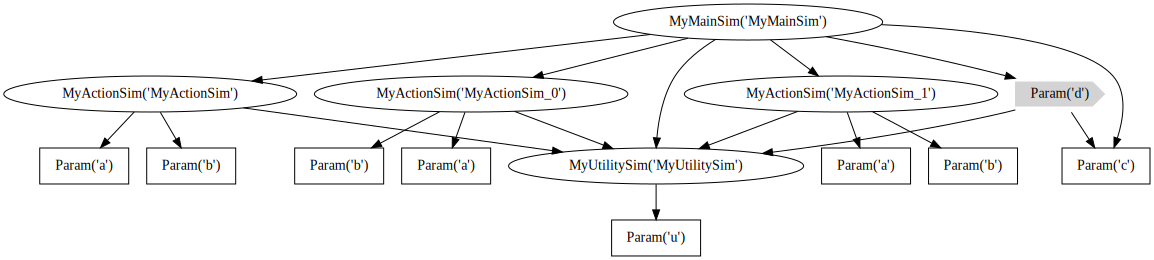

In [12]:
main.graphviz()

## Interacting with PyTorch

The above `list` version of `params` is very convenient since we could build it alongside building the simulator. The `Tensor` version is also convenient since we can easily use it alongside PyTorch autograd or vmap functionalities. Here we will see how this lets us use PyTorch capabilities. We will also see how we may pass batched parameters into `caskade` simulators.

In [13]:
# Using PyTorch autograd
params_tensor = torch.cat(tuple(p.flatten() for p in params)) # flattened vector with shape (8,)
print("mymainfunction gradient: ", torch.func.grad(main.mymainfunction,argnums=1)(1.0, params_tensor))

# Using PyTorch vmap
batched_params = torch.stack([params_tensor, params_tensor, params_tensor]) # batched parameters with shape (3, 8)
print("mymainfunction batched: ", torch.vmap(main.mymainfunction)(torch.tensor([1.0, 2.0, 3.0]), batched_params))

mymainfunction gradient:  tensor([1272.,  522.,   18.,  270.,    9.,  186.,    3.,  294.])
mymainfunction batched:  tensor([558., 594., 630.])


Note that it is also possible for `Module` objects to accept batched parameters. However, keep in mind that this simply means passing through the parameters normally, except with extra dimensions. You can/will get different behavior than vmap, which is closer to treating the batch dimension as a `for-loop`. This may actually be the desired effect, it's up to you to build the simulator accordingly. To understand what is going on, consider the current simulator, each parameter is a scalar and the batch dimension is `(3,)` so with tuple addition the dimensionality of each parameter becomes `(3,) + () = (3,)`. If instead of scalars, we had set the shapes to all be length 1 vectors `(1,)` then the resulting dimensions as passed through `caskade` would be `(3,) + (1,) = (3,1)` which would behave differently through the simulator as we can see below. We can see that the shape of other input parameters (`x`) also affect the results, as would be expected since the tensor shapes are interacting according to how we built our simulator.

In [14]:
main.a_utility.u.shape = (1,) # set as a length 1 vector
print("utility u length 1 vector:\n------------------------")
print("mymainfunction internally batched x.shape=(3,): ", main.mymainfunction(torch.tensor([1.0, 2.0, 3.0]), batched_params))
print("mymainfunction internally batched x.shape=(3,1): ", main.mymainfunction(torch.tensor([[1.0], [2.0], [3.0]]), batched_params))
print()
main.a_utility.u.shape = () # set as a scalar (like everything else)
print("utility u scalar:\n------------------------")
print("mymainfunction internally batched x.shape=(3,): ", main.mymainfunction(torch.tensor([1.0, 2.0, 3.0]), batched_params))
print("mymainfunction internally batched x.shape=(3,1): ", main.mymainfunction(torch.tensor([[1.0], [2.0], [3.0]]), batched_params))


utility u length 1 vector:
------------------------
mymainfunction internally batched x.shape=(3,):  tensor([[558., 594., 630.],
        [558., 594., 630.],
        [558., 594., 630.]])
mymainfunction internally batched x.shape=(3,1):  tensor([[558., 558., 558.],
        [594., 594., 594.],
        [630., 630., 630.]])

utility u scalar:
------------------------
mymainfunction internally batched x.shape=(3,):  tensor([558., 594., 630.])
mymainfunction internally batched x.shape=(3,1):  tensor([[558., 558., 558.],
        [594., 594., 594.],
        [630., 630., 630.]])


What if we want only one parameter to be batched? Or what about two parameters having different batch dimensions? Well in this case it is not possible build a single `Tensor` to encapsulate this capability since a tensor must have a shape like `(int1, int2, int3, ...)`. However, this is not a restriction for the `list` or `dict` inputs to a `caskade` simulator! Simply set the elements however you like, just take note that it's up to you to build the simulator accordingly.

In [15]:
params_funky = params
params_funky[0] = torch.tensor([1.0, 2.0, 3.0]) # shape (3,)
params_funky[1] = torch.tensor([[1.0], [0.0], [-1.0]]) # shape (3, 1)
params_funky[2] = torch.arange(9).reshape((3,3,1)) # shape (3, 3, 1)
# now the first three parameters are funky shapes with params_funky[2] even having a different set of batch dimensions
print("mymainfunction funky: ", main.mymainfunction(1.0, params_funky))

mymainfunction funky:  tensor([[[  1062.,   9885.,  45402.],
         [   558.,   3360.,  11466.],
         [    54.,  -3165., -22470.]],

        [[  1116.,  10020.,  45654.],
         [   612.,   3495.,  11718.],
         [   108.,  -3030., -22218.]],

        [[  1170.,  10155.,  45906.],
         [   666.,   3630.,  11970.],
         [   162.,  -2895., -21966.]]])


And we're done! Those are all the elemental abilities of `caskade`, I hope that by this point you have a sense of the vast possibilities of simulators that can be constructed. Happy science-ing!